<a href="https://colab.research.google.com/github/FathimaNazarudeen/medical/blob/main/medical.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pretrainedmodels
!pip install torchsummary
!pip install imutils
!pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 58 kB 6.1 MB/s 
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60966 sha256=445972fb2bd4f0d489514857580cbd696894d73fab61e3cdd44a926c956222e7
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built pretrainedmodels
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import torch
from torch.utils.data import DataLoader,Dataset
from torchvision import transforms
from sklearn.preprocessing import LabelEncoder
from torchsummary import summary
from torch import nn
import torch.nn.functional as F
from imutils import paths
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import pretrainedmodels
import torchvision
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
root='/content/drive/MyDrive/Fathima_dataset'

In [ ]:
classes=('positive','negative')

In [ ]:
image_paths = list(paths.list_images('/content/drive/MyDrive/Fathima_dataset'))

data = []
labels = []
for img_path in image_paths:
    label = img_path.split(os.path.sep)[-2]
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    data.append(img)
    labels.append(label)
    
data = np.array(data)
labels = np.array(labels)

In [ ]:
labels

array(['positive', 'positive', 'positive', ..., 'negative', 'negative',
       'negative'], dtype='<U8')

In [ ]:
lb = LabelEncoder()
labels = lb.fit_transform(labels)
print(f"Total Number of Classes: {len(lb.classes_)}")

Total Number of Classes: 2


In [ ]:
train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5)])

val_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5)])    

In [ ]:
# divide the data into train, validation, and test set
(X, x_val , Y, y_val) = train_test_split(data, labels, test_size=0.2,  stratify=labels,random_state=42)
(x_train, x_test, y_train, y_test) = train_test_split(X, Y, test_size=0.25, random_state=42)
print(f"x_train examples: {x_train.shape}\nx_test examples: {x_test.shape}\nx_val examples: {x_val.shape}")

x_train examples: (4077, 40, 40, 3)
x_test examples: (1359, 40, 40, 3)
x_val examples: (1360, 40, 40, 3)


In [ ]:
batch_size=6

In [ ]:
# custom dataset class
class CustomDataset(Dataset):
    def __init__(self, images, labels, transforms = None):
        self.labels = labels
        self.images = images
        self.transforms = transforms
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        data = self.images[index][:]
        labels = self.labels[index]
        
        if self.transforms:
            data = self.transforms(data)
            
            return data,labels

train_data = CustomDataset(x_train, y_train, train_transforms)
val_data = CustomDataset(x_val, y_val, val_transform)
test_data = CustomDataset(x_test, y_test, val_transform)       

trainLoader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=4)
valLoader = DataLoader(val_data, batch_size=64, shuffle=True, num_workers=4)
testLoader = DataLoader(test_data, batch_size=64, shuffle=True, num_workers=4) 


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
for X, y in trainLoader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 3, 299, 299])
Shape of y: torch.Size([64]) torch.int64


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [ ]:
# the resnet34 model
class inceptionV3(nn.Module):
    def __init__(self, pretrained):
        super(inceptionV3, self).__init__()
        if pretrained is True:
            self.model = pretrainedmodels.__dict__['inceptionv3'](pretrained='imagenet')
        else:
            self.model = pretrainedmodels.__dict__['inceptionv3'](pretrained = None)
        # change the classification layer
        self.l0= nn.Linear(2048, len(lb.classes_))
        self.dropout = nn.Dropout2d(0.4)
        
    def forward(self, x):
        # get the batch size only, ignore(c, h, w)
        batch, _, _, _ = x.shape
        x = self.model.features(x)
        x = F.adaptive_avg_pool2d(x, 1).reshape(batch, -1)
        x = self.dropout(x)
        l0 = self.l0(x)
        return l0

model = inceptionV3(pretrained=True).to(device)
print(model)

inceptionV3(
  (model): Inception3(
    (Conv2d_1a_3x3): BasicConv2d(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_2a_3x3): BasicConv2d(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_2b_3x3): BasicConv2d(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (Conv2d_3b_1x1): BasicConv2d(
      (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_4a_3x3): Basic

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = inceptionV3(pretrained=True).to(device)

#model.load_state_dict(torch.load("/kaggle/working/model.pth", map_location= device))

model.to(device)
summary(model, (3, 299, 299))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 149, 149]             864
       BatchNorm2d-2         [-1, 32, 149, 149]              64
       BasicConv2d-3         [-1, 32, 149, 149]               0
            Conv2d-4         [-1, 32, 147, 147]           9,216
       BatchNorm2d-5         [-1, 32, 147, 147]              64
       BasicConv2d-6         [-1, 32, 147, 147]               0
            Conv2d-7         [-1, 64, 147, 147]          18,432
       BatchNorm2d-8         [-1, 64, 147, 147]             128
       BasicConv2d-9         [-1, 64, 147, 147]               0
           Conv2d-10           [-1, 80, 73, 73]           5,120
      BatchNorm2d-11           [-1, 80, 73, 73]             160
      BasicConv2d-12           [-1, 80, 73, 73]               0
           Conv2d-13          [-1, 192, 71, 71]         138,240
      BatchNorm2d-14          [-1, 192,

In [ ]:
# loss function
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

save_path = "model.pth"

In [ ]:
epochs=50

In [ ]:
def train(model,trainloader):    
    # training function
    for epoch in range(epochs):
        print('Training')
        model.train()
        running_loss = 0.0
        running_correct = 0
        for batch, (X, y) in enumerate(tqdm(trainloader)):


            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            outputs = model(X)
            loss = loss_fn(outputs, y)
            
            running_loss += loss.item()

            running_correct += (outputs.argmax(1) == y).type(torch.float).sum().item()
            
            
            
            loss.backward()
            optimizer.step()

            #running_loss += loss.item()

            #running_correct += (outputs.argmax(1) == y).type(torch.float).sum().item()


        loss = running_loss/len(trainloader.dataset)
        accuracy = 100. * running_correct/len(trainloader.dataset)

        print(f"Train Loss: {loss:.4f}, Train Acc: {accuracy:.2f}")

        return loss, accuracy


In [ ]:
#validation function
def validate(model, dataloader):
    print('Validating')
    model.eval()
    running_loss = 0.0
    running_correct = 0
    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            # Compute prediction error
            pred = model(X)
            loss = loss_fn(pred, y)
            running_loss += loss_fn(pred, y).item()        
            running_correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        
        loss = running_loss/len(dataloader.dataset)
        accuracy = 100. * running_correct/len(dataloader.dataset)
        print(f'Val Loss: {loss:.4f}, Val Acc: {accuracy:.2f}')
        
        return loss, accuracy

In [ ]:
def test(model, dataloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            total += y.size(0)
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    return correct, total

In [ ]:
epochs=50


train_loss , train_accuracy = [], []
val_loss , val_accuracy = [], []
print(f"Training on {len(train_data)} examples, validating on {len(val_data)} examples...")

for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_accuracy = train(model, trainLoader)
    val_epoch_loss, val_epoch_accuracy = validate(model, valLoader)
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

Training on 4077 examples, validating on 1360 examples...
Epoch 1 of 50
Training


100%|██████████| 64/64 [01:00<00:00,  1.06it/s]

Train Loss: 0.0041, Train Acc: 89.31
Validating


Val Loss: 0.0051, Val Acc: 85.07
Epoch 2 of 50
Training


100%|██████████| 64/64 [00:59<00:00,  1.07it/s]

Train Loss: 0.0025, Train Acc: 95.19
Validating


Val Loss: 0.0022, Val Acc: 94.56
Epoch 3 of 50
Training


100%|██████████| 64/64 [00:59<00:00,  1.07it/s]

Train Loss: 0.0020, Train Acc: 95.12
Validating


Val Loss: 0.0023, Val Acc: 95.81
Epoch 4 of 50
Training


100%|██████████| 64/64 [00:59<00:00,  1.07it/s]

Train Loss: 0.0017, Train Acc: 96.03
Validating


Val Loss: 0.0025, Val Acc: 95.51
Epoch 5 of 50
Training


100%|██████████| 64/64 [01:00<00:00,  1.07it/s]

Train Loss: 0.0014, Train Acc: 96.69
Validating


Val Loss: 0.0028, Val Acc: 93.97
Epoch 6 of 50
Training


100%|██████████| 64/64 [00:59<00:00,  1.07it/s]

Train Loss: 0.0015, Train Acc: 96.42
Validating


Val Loss: 0.0018, Val Acc: 95.66
Epoch 7 of 50
Training


100%|██████████| 64/64 [00:59<00:00,  1.07it/s]

Train Loss: 0.0014, Train Acc: 96.84
Validating


Val Loss: 0.0025, Val Acc: 94.56
Epoch 8 of 50
Training


100%|██████████| 64/64 [00:59<00:00,  1.07it/s]

Train Loss: 0.0013, Train Acc: 97.23
Validating


Val Loss: 0.0026, Val Acc: 94.56
Epoch 9 of 50
Training


100%|██████████| 64/64 [01:00<00:00,  1.06it/s]

Train Loss: 0.0014, Train Acc: 96.69
Validating


Val Loss: 0.0015, Val Acc: 97.28
Epoch 10 of 50
Training


100%|██████████| 64/64 [00:59<00:00,  1.07it/s]

Train Loss: 0.0011, Train Acc: 97.42
Validating


Val Loss: 0.0020, Val Acc: 94.93
Epoch 11 of 50
Training


100%|██████████| 64/64 [00:59<00:00,  1.07it/s]

Train Loss: 0.0011, Train Acc: 97.42
Validating


Val Loss: 0.0023, Val Acc: 95.96
Epoch 12 of 50
Training


100%|██████████| 64/64 [01:00<00:00,  1.07it/s]

Train Loss: 0.0013, Train Acc: 96.98
Validating


Val Loss: 0.0025, Val Acc: 94.71
Epoch 13 of 50
Training


100%|██████████| 64/64 [00:59<00:00,  1.07it/s]

Train Loss: 0.0013, Train Acc: 97.11
Validating


Val Loss: 0.0026, Val Acc: 94.56
Epoch 14 of 50
Training


100%|██████████| 64/64 [01:00<00:00,  1.07it/s]

Train Loss: 0.0009, Train Acc: 97.89
Validating


Val Loss: 0.0019, Val Acc: 95.37
Epoch 15 of 50
Training


100%|██████████| 64/64 [00:59<00:00,  1.07it/s]

Train Loss: 0.0011, Train Acc: 97.52
Validating


Val Loss: 0.0016, Val Acc: 96.10
Epoch 16 of 50
Training


100%|██████████| 64/64 [00:59<00:00,  1.07it/s]

Train Loss: 0.0009, Train Acc: 97.92
Validating


Val Loss: 0.0013, Val Acc: 97.21
Epoch 17 of 50
Training


100%|██████████| 64/64 [00:59<00:00,  1.07it/s]

Train Loss: 0.0008, Train Acc: 98.04
Validating


Val Loss: 0.0013, Val Acc: 96.69
Epoch 18 of 50
Training


100%|██████████| 64/64 [00:59<00:00,  1.07it/s]

Train Loss: 0.0007, Train Acc: 98.14
Validating


Val Loss: 0.0016, Val Acc: 96.47
Epoch 19 of 50
Training


100%|██████████| 64/64 [01:00<00:00,  1.07it/s]

Train Loss: 0.0008, Train Acc: 98.23
Validating


Val Loss: 0.0015, Val Acc: 97.06
Epoch 20 of 50
Training


100%|██████████| 64/64 [01:00<00:00,  1.07it/s]

Train Loss: 0.0007, Train Acc: 98.26
Validating


Val Loss: 0.0019, Val Acc: 96.18
Epoch 21 of 50
Training


100%|██████████| 64/64 [00:59<00:00,  1.07it/s]

Train Loss: 0.0009, Train Acc: 97.67
Validating


Val Loss: 0.0019, Val Acc: 96.84
Epoch 22 of 50
Training


100%|██████████| 64/64 [01:00<00:00,  1.06it/s]

Train Loss: 0.0007, Train Acc: 98.43
Validating


Val Loss: 0.0015, Val Acc: 97.35
Epoch 23 of 50
Training


100%|██████████| 64/64 [01:00<00:00,  1.07it/s]

Train Loss: 0.0006, Train Acc: 98.60
Validating


Val Loss: 0.0016, Val Acc: 96.62
Epoch 24 of 50
Training


100%|██████████| 64/64 [00:59<00:00,  1.07it/s]

Train Loss: 0.0006, Train Acc: 98.38
Validating


Val Loss: 0.0017, Val Acc: 96.84
Epoch 25 of 50
Training


100%|██████████| 64/64 [01:00<00:00,  1.06it/s]

Train Loss: 0.0006, Train Acc: 98.33
Validating


Val Loss: 0.0016, Val Acc: 96.99
Epoch 26 of 50
Training


100%|██████████| 64/64 [01:00<00:00,  1.07it/s]

Train Loss: 0.0006, Train Acc: 98.33
Validating


Val Loss: 0.0021, Val Acc: 95.59
Epoch 27 of 50
Training


100%|██████████| 64/64 [00:59<00:00,  1.07it/s]

Train Loss: 0.0009, Train Acc: 98.11
Validating


Val Loss: 0.0016, Val Acc: 96.18
Epoch 28 of 50
Training


100%|██████████| 64/64 [01:00<00:00,  1.07it/s]

Train Loss: 0.0008, Train Acc: 98.26
Validating


Val Loss: 0.0016, Val Acc: 96.91
Epoch 29 of 50
Training


100%|██████████| 64/64 [01:00<00:00,  1.07it/s]

Train Loss: 0.0006, Train Acc: 98.48
Validating


Val Loss: 0.0018, Val Acc: 96.25
Epoch 30 of 50
Training


100%|██████████| 64/64 [00:59<00:00,  1.07it/s]

Train Loss: 0.0006, Train Acc: 98.75
Validating


Val Loss: 0.0017, Val Acc: 97.50
Epoch 31 of 50
Training


100%|██████████| 64/64 [00:59<00:00,  1.07it/s]

Train Loss: 0.0008, Train Acc: 98.11
Validating


Val Loss: 0.0020, Val Acc: 95.44
Epoch 32 of 50
Training


100%|██████████| 64/64 [01:00<00:00,  1.07it/s]

Train Loss: 0.0006, Train Acc: 98.50
Validating


Val Loss: 0.0014, Val Acc: 97.13
Epoch 33 of 50
Training


100%|██████████| 64/64 [01:00<00:00,  1.06it/s]

Train Loss: 0.0006, Train Acc: 98.63
Validating


Val Loss: 0.0014, Val Acc: 97.13
Epoch 34 of 50
Training


100%|██████████| 64/64 [01:00<00:00,  1.06it/s]

Train Loss: 0.0005, Train Acc: 98.99
Validating


Val Loss: 0.0014, Val Acc: 98.09
Epoch 35 of 50
Training


100%|██████████| 64/64 [01:00<00:00,  1.06it/s]

Train Loss: 0.0004, Train Acc: 99.04
Validating


Val Loss: 0.0016, Val Acc: 96.84
Epoch 36 of 50
Training


100%|██████████| 64/64 [01:00<00:00,  1.07it/s]

Train Loss: 0.0006, Train Acc: 98.65
Validating


Val Loss: 0.0022, Val Acc: 97.28
Epoch 37 of 50
Training


100%|██████████| 64/64 [00:59<00:00,  1.07it/s]

Train Loss: 0.0004, Train Acc: 99.07
Validating


Val Loss: 0.0018, Val Acc: 96.47
Epoch 38 of 50
Training


100%|██████████| 64/64 [01:00<00:00,  1.07it/s]

Train Loss: 0.0002, Train Acc: 99.61
Validating


Val Loss: 0.0017, Val Acc: 97.50
Epoch 39 of 50
Training


100%|██████████| 64/64 [00:59<00:00,  1.07it/s]

Train Loss: 0.0006, Train Acc: 98.63
Validating


Val Loss: 0.0014, Val Acc: 97.35
Epoch 40 of 50
Training


100%|██████████| 64/64 [01:00<00:00,  1.07it/s]

Train Loss: 0.0005, Train Acc: 98.75
Validating


Val Loss: 0.0018, Val Acc: 97.06
Epoch 41 of 50
Training


100%|██████████| 64/64 [01:00<00:00,  1.07it/s]

Train Loss: 0.0006, Train Acc: 98.82
Validating


Val Loss: 0.0025, Val Acc: 95.88
Epoch 42 of 50
Training


100%|██████████| 64/64 [00:59<00:00,  1.07it/s]

Train Loss: 0.0006, Train Acc: 98.63
Validating


Val Loss: 0.0020, Val Acc: 95.07
Epoch 43 of 50
Training


100%|██████████| 64/64 [00:59<00:00,  1.07it/s]

Train Loss: 0.0005, Train Acc: 98.92
Validating


Val Loss: 0.0020, Val Acc: 96.18
Epoch 44 of 50
Training


100%|██████████| 64/64 [00:59<00:00,  1.07it/s]

Train Loss: 0.0004, Train Acc: 99.31
Validating


Val Loss: 0.0023, Val Acc: 97.13
Epoch 45 of 50
Training


100%|██████████| 64/64 [01:00<00:00,  1.07it/s]

Train Loss: 0.0003, Train Acc: 99.09
Validating


Val Loss: 0.0021, Val Acc: 96.18
Epoch 46 of 50
Training


100%|██████████| 64/64 [01:00<00:00,  1.07it/s]

Train Loss: 0.0003, Train Acc: 99.41
Validating


Val Loss: 0.0019, Val Acc: 97.43
Epoch 47 of 50
Training


100%|██████████| 64/64 [00:59<00:00,  1.07it/s]

Train Loss: 0.0002, Train Acc: 99.58
Validating


Val Loss: 0.0022, Val Acc: 97.21
Epoch 48 of 50
Training


100%|██████████| 64/64 [01:00<00:00,  1.07it/s]

Train Loss: 0.0002, Train Acc: 99.39
Validating


Val Loss: 0.0018, Val Acc: 97.87
Epoch 49 of 50
Training


100%|██████████| 64/64 [00:59<00:00,  1.07it/s]

Train Loss: 0.0006, Train Acc: 98.77
Validating


Val Loss: 0.0020, Val Acc: 96.47
Epoch 50 of 50
Training


100%|██████████| 64/64 [01:00<00:00,  1.07it/s]

Train Loss: 0.0004, Train Acc: 99.17
Validating


Val Loss: 0.0015, Val Acc: 97.43


In [ ]:
torch.save(model.state_dict(), save_path)
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


In [ ]:
model = inceptionV3(pretrained=True).to(device)
#model.load_state_dict(torch.load("model.pth"))

state_dict = torch.load(f"/content/{save_path}")
model.load_state_dict(state_dict)

<All keys matched successfully>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


# Function to show the images
def imageshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# Function to test the model with a batch of images and show the labels predictions
def testBatch():
    # get batch of images from the test DataLoader  
    images, labels = next(iter(testLoader))

    # show all images as one image grid
    imageshow(torchvision.utils.make_grid(images))
   
    # Show the real labels on the screen 
    print('Real labels: ', ' '.join('%5s' % classes[labels[j]] 
                               for j in range(batch_size)))
  
    # Let's see what if the model identifiers the  labels of those example
    images=images.to(device)
    outputs = model(images)
    
    # We got the probability for every 10 labels. The highest (max) probability should be correct label
    _, predicted = torch.max(outputs, 1)
    
    # Let's show the predicted labels on the screen to compare with the real ones
    print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] 
                              for j in range(batch_size)))

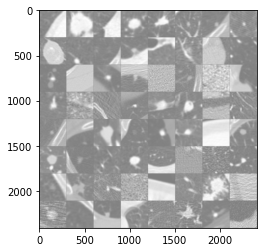

Real labels:  positive negative positive negative negative negative
Predicted:  positive negative positive negative negative negative


In [ ]:
testBatch()

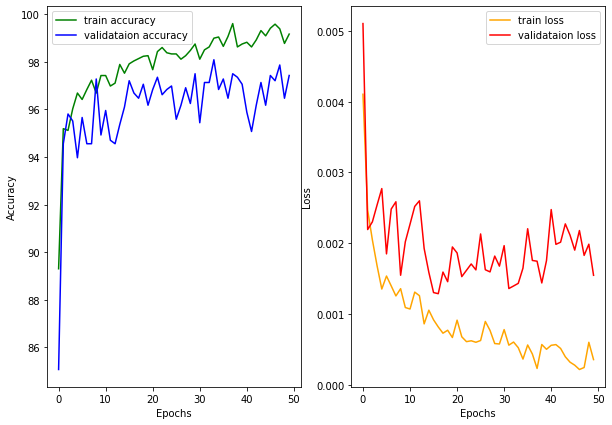

In [ ]:
# accuracy plots
plt.figure(figsize=(10, 7))
plt.subplot(121)
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.plot(val_accuracy, color='blue', label='validataion accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
# plt.savefig('../outputs/plots/accuracy.png')
# loss plots
plt.subplot(122)
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validataion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
# plt.savefig('../outputs/plots/loss.png')
plt.show()